In [49]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/typing_extensions.py", line 844, in <module>
    class SupportsAbs(P

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def get_common_configs():
    color_scheme = {128: "#1f77b4", 1024: "#2ca02c", 8192: "#ff7f0e", 64: "#1f77b4", 288: "#ff7f0e"}
    marker_scheme = {128: "o", 1024: "v", 8192: "s", 64: "o", 288: "s"}
    linestyle_scheme = {"Vanilla NN": "-", "GNN": ":", "Data-Driven NN": "-"}
    return color_scheme, marker_scheme, linestyle_scheme

def make_legends(linestyle_scheme, color_scheme, marker_scheme):
    arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
                  for arch in linestyle_scheme.keys()]
    sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                                linestyle='none', label=f'{size}', markersize=8)
                     for size in color_scheme.keys()]
    return arch_lines, sample_patches

def setup_results_interpreter():
    results_interpretor = rri.RayResultsinterpreter()
    def custom_data_filler(out_row, reference_row): out_row['path'] = reference_row['path']
    def default_condition_setter(condition_name): return None
    return results_interpretor, custom_data_filler, default_condition_setter

# --- Data Parse Functions ---

def parse_serial_system():
    testset_name = "finals_serial"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
        "GNN": lambda: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = ["serial_system_3", "serial_system_4", "serial_system_5", "serial_system_6", "serial_system_7"]
    sample_sizes = [128, 1024, 8192]
    test_loss_column = 'Test Loss'
    dfs = []
    for arch_name, path_fn in architectures.items():
        path = path_fn()
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'store_lead_time': [4],
             'samples': [1],
             'config': configs},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['system_length'] = df['config'].apply(lambda c: int(str(c).split('_')[-1]))
        # Read test loss from file, using config-specific filename
        test_losses = []
        for _, row in df.iterrows():
            test_loss_path = str(row['path']) + "/" + row['config'] + "_5000_test_loss.txt"
            try:
                with open(test_loss_path, 'r') as f:
                    value = float(f.read().strip())
            except Exception:
                value = np.nan
            test_losses.append(value)
        df[test_loss_column] = test_losses
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    results = []
    for system_length in [int(config.split('_')[-1]) for config in configs]:
        for sample_size in sample_sizes:
            vanilla_rows = df[
                (df['system_length'] == system_length) &
                (df['train_dev_sample_and_batch_size'] == sample_size) &
                (df['Architecture Class'] == "Vanilla NN")
            ]
            gnn_rows = df[
                (df['system_length'] == system_length) &
                (df['train_dev_sample_and_batch_size'] == sample_size) &
                (df['Architecture Class'] == "GNN")
            ]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows[test_loss_column].mean()
            gnn_loss = gnn_rows[test_loss_column].mean()
            improvement = (vanilla_loss - gnn_loss) / gnn_loss * 100
            results.append({
                'setting': 'serial_system',
                'sample_size': sample_size,
                'system_length': system_length,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "system_length",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "configs": configs
        }
    }

def parse_one_warehouse():
    testset_name = "finals_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse',
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    test_loss_filename = 'one_warehouse_lost_demand_5000_test_loss.txt'
    test_loss_column = 'Test Loss'
    dfs = []
    for arch_name, path_fn in architectures.items():
        path = path_fn(None)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'store_lead_time': [[2, 6]],
             'samples': [1],
             'n_stores': n_stores},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        # Read test loss from file
        test_losses = []
        for _, row in df.iterrows():
            test_loss_path = str(row['path']) + "/" + test_loss_filename
            try:
                with open(test_loss_path, 'r') as f:
                    value = float(f.read().strip())
            except Exception:
                value = np.nan
            test_losses.append(value)
        df[test_loss_column] = test_losses
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['n_stores'].astype(int)
    results = []
    for sample_size in sample_sizes:
        for n_store in n_stores:
            vanilla_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Vanilla NN")]
            gnn_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows[test_loss_column].mean()
            gnn_loss = gnn_rows[test_loss_column].mean()
            improvement = (vanilla_loss - gnn_loss) / gnn_loss * 100
            results.append({
                'setting': 'one_warehouse',
                'sample_size': sample_size,
                'n_stores': n_store,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "n_stores_list": n_stores
        }
    }

def parse_transshipment():
    testset_name = "finals_transshipment"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment_50',
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment_50',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    lower_bounds = {
        3: 8.533673716946652,
        5: 7.902133198919353,
        10: 8.296968310182638,
        20: 8.731082080524004,
        30: 8.37732777290095,
        50: 8.118102268777966,
    }
    test_loss_filename = 'transshipment_backlogged_5000_test_loss.txt'
    test_loss_column = 'Test Loss'
    dfs = []
    for arch_name, path_fn in architectures.items():
        path = path_fn(None)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'store_lead_time': [4],
             'samples': [1],
             'n_stores': n_stores},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        # Read test loss from file
        test_losses = []
        for _, row in df.iterrows():
            test_loss_path = str(row['path']) + "/" + test_loss_filename
            try:
                with open(test_loss_path, 'r') as f:
                    value = float(f.read().strip())
            except Exception:
                value = np.nan
            test_losses.append(value)
        df[test_loss_column] = test_losses
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['n_stores'].astype(int)
    results = []
    for sample_size in sample_sizes:
        for n_store in n_stores:
            vanilla_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Vanilla NN")]
            gnn_rows = df[(df['n_stores'] == n_store) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows[test_loss_column].mean()
            gnn_loss = gnn_rows[test_loss_column].mean()
            improvement = (vanilla_loss - gnn_loss) / gnn_loss * 100
            results.append({
                'setting': 'transshipment',
                'sample_size': sample_size,
                'n_stores': n_store,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "n_stores_list": n_stores
        }
    }

def parse_real_one_warehouse():
    testset_name = "finals_real_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    }
    store_counts = [3, 5, 10, 15, 21]
    sample_sizes = [64, 288]
    dfs = []
    for arch_name, path in architectures.items():
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'n_stores': store_counts,
             'test_n_samples': sample_sizes},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['n_stores'].astype(int)
    results = []
    for sample_size in sample_sizes:
        for n_stores in store_counts:
            vanilla_rows = df[(df['n_stores'] == n_stores) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Data-Driven NN")]
            gnn_rows = df[(df['n_stores'] == n_stores) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = (gnn_loss - vanilla_loss) / vanilla_loss * 100
            results.append({
                'setting': 'real_one_warehouse',
                'sample_size': sample_size,
                'n_stores': n_stores,
                'improvement_percentage': improvement
            })
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "n_stores_list": store_counts
        }
    }

def parse_many_warehouses():
    import numpy as np
    testset_name = "finals_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_warehouses',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = [
        "n_warehouse_10_2_lost_demand",
        "n_warehouse_20_3_lost_demand",
        "n_warehouse_30_4_lost_demand", 
        "n_warehouse_40_5_lost_demand", 
        "n_warehouse_50_6_lost_demand"
    ]
    config_to_stores_warehouses = {
        "n_warehouse_10_2_lost_demand": (10, 2),
        "n_warehouse_20_3_lost_demand": (20, 3),
        "n_warehouse_30_4_lost_demand": (30, 4),
        "n_warehouse_40_5_lost_demand": (40, 5),
        "n_warehouse_50_6_lost_demand": (50, 6)
    }
    sample_sizes = [128, 1024, 8192]
    test_loss_column = 'Test Loss'
    dfs = []
    for arch_name, path in architectures.items():
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'store_underage_cost': [9],
             'config': configs,
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        # Read test loss from file
        test_losses = []
        for _, row in df.iterrows():
            test_loss_path = str(row['path']) + "/" + row['config'] + "_5000_test_loss.txt"
            try:
                with open(test_loss_path, 'r') as f:
                    value = float(f.read().strip())
            except Exception:
                value = np.nan
            test_losses.append(value)
        df[test_loss_column] = test_losses
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_stores'] = df['config'].map(lambda c: config_to_stores_warehouses[c][0])
    df['n_warehouses'] = df['config'].map(lambda c: config_to_stores_warehouses[c][1])
    results = []
    for sample_size in sample_sizes:
        for config in configs:
            vanilla_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Vanilla NN")]
            gnn_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows[test_loss_column].mean()
            gnn_loss = gnn_rows[test_loss_column].mean()
            improvement = (vanilla_loss - gnn_loss) / gnn_loss * 100
            results.append({
                'setting': 'many_warehouses',
                'sample_size': sample_size,
                'config': config,
                'n_stores': config_to_stores_warehouses[config][0],
                'n_warehouses': config_to_stores_warehouses[config][1],
                'improvement_percentage': improvement
            })
    x_ticks = [10, 20, 30, 40, 50]
    x_tick_labels = []
    for n_stores in x_ticks:
        for config, (stores, warehouses) in config_to_stores_warehouses.items():
            if stores == n_stores:
                x_tick_labels.append(f"({stores},{warehouses})")
                break
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_stores",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "configs": configs,
            "x_ticks": x_ticks,
            "x_tick_labels": x_tick_labels
        }
    }

def parse_real_many_warehouses():
    testset_name = "finals_real_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_n_warehouses_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    }
    configs = [
        "n_warehouse_21_2_real_lost_demand",
        "n_warehouse_21_3_real_lost_demand",
        "n_warehouse_21_4_real_lost_demand",
        "n_warehouse_21_5_real_lost_demand"
    ]
    config_to_warehouses = {
        "n_warehouse_21_2_real_lost_demand": 2,
        "n_warehouse_21_3_real_lost_demand": 3,
        "n_warehouse_21_4_real_lost_demand": 4,
        "n_warehouse_21_5_real_lost_demand": 5
    }
    sample_sizes = [64, 288]
    dfs = []
    for arch_name, path in architectures.items():
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes,
             'config': configs,
             'test_n_samples': sample_sizes},
            default_condition_setter, custom_data_filler,
            sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
        if df.empty: continue
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    df['n_warehouses'] = df['config'].map(lambda c: config_to_warehouses[c])
    results = []
    for sample_size in sample_sizes:
        for config in configs:
            vanilla_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "Data-Driven NN")]
            gnn_rows = df[(df['config'] == config) & (df['train_dev_sample_and_batch_size'] == sample_size) & (df['Architecture Class'] == "GNN")]
            if vanilla_rows.empty or gnn_rows.empty:
                continue
            vanilla_loss = vanilla_rows['Test Loss'].mean()
            gnn_loss = gnn_rows['Test Loss'].mean()
            improvement = (gnn_loss - vanilla_loss) / vanilla_loss * 100
            results.append({
                'setting': 'real_many_warehouses',
                'sample_size': sample_size,
                'config': config,
                'n_warehouses': config_to_warehouses[config],
                'improvement_percentage': improvement
            })
    x_ticks = sorted(list(config_to_warehouses.values()))
    return {
        "results": results,
        "meta": {
            "linestyle_scheme": linestyle_scheme,
            "color_scheme": color_scheme,
            "marker_scheme": marker_scheme,
            "x_axis": "n_warehouses",
            "sample_sizes": sample_sizes,
            "architectures": list(architectures.keys()),
            "configs": configs,
            "x_ticks": x_ticks
        }
    }

# --- Data Loading ---
serial_system_data = parse_serial_system()
one_warehouse_data = parse_one_warehouse()
real_one_warehouse_data = parse_real_one_warehouse()
transshipment_data = parse_transshipment()
many_warehouses_data = parse_many_warehouses()
real_many_warehouses_data = parse_real_many_warehouses()

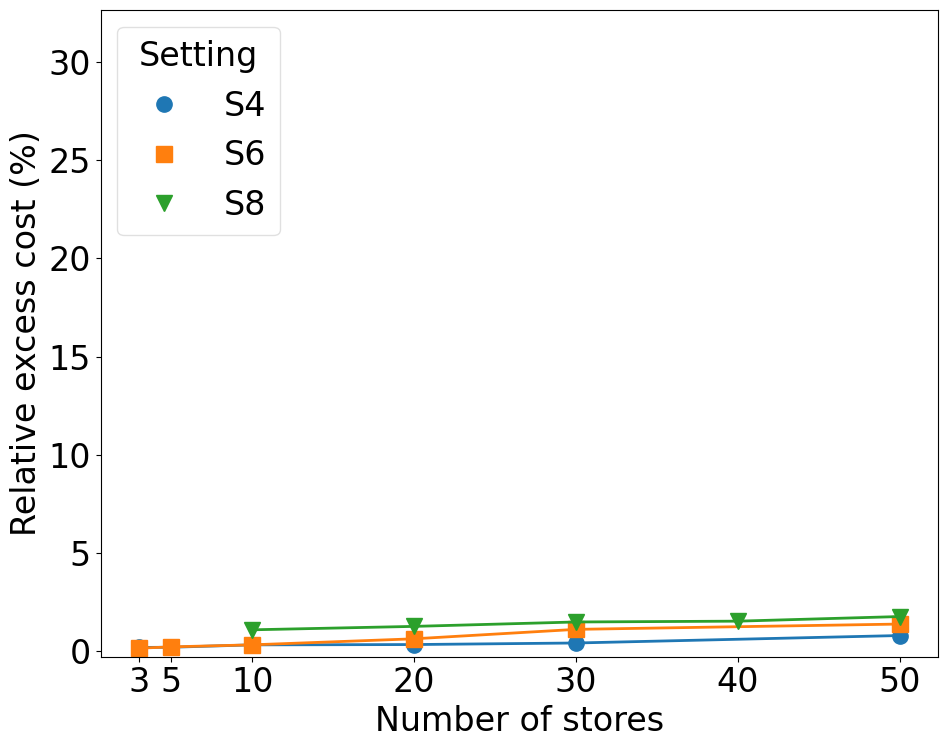

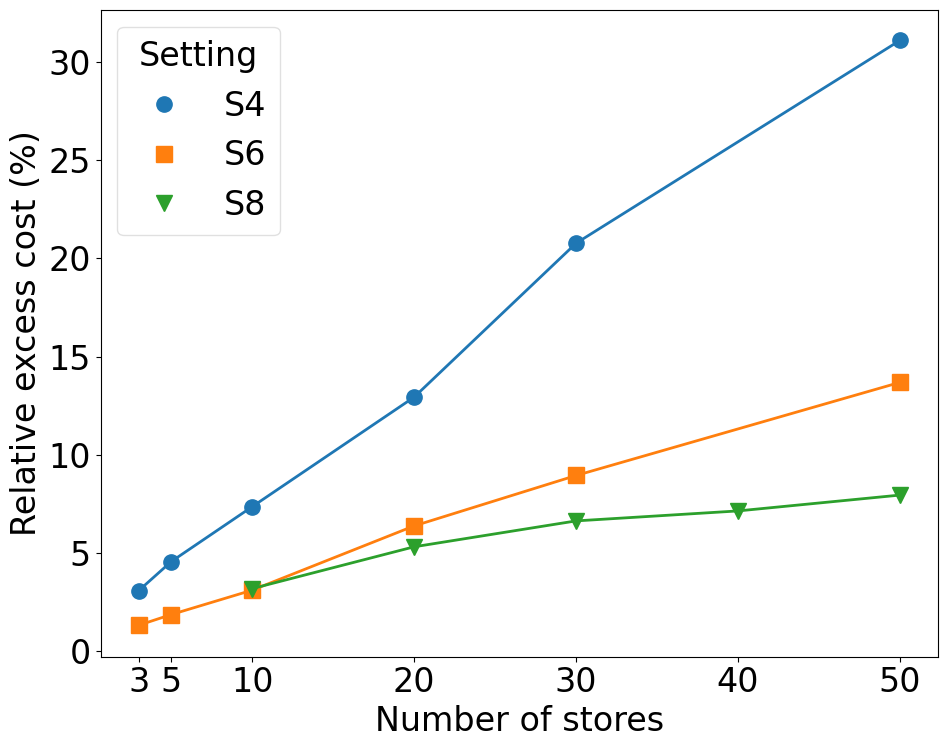

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

FONTSIZE = 24
MARKERSIZE = 11
LINEWIDTH = 2
FIGSIZE = (10, 8)
plt.rcParams.update({'font.size': FONTSIZE})

scenario_data = {
    "Transshipment": transshipment_data,
    "One Warehouse": one_warehouse_data,
    "Many Warehouses": many_warehouses_data,
}

problem_size_fields = {
    "Transshipment": "n_stores",
    "One Warehouse": "n_stores",
    "Many Warehouses": "n_stores",
    "Real One Warehouse": "n_stores",
    "Real Many Warehouses": "n_warehouses",
}
sample_size_fields = {
    "Transshipment": "sample_size",
    "One Warehouse": "sample_size",
    "Many Warehouses": "sample_size",
}

# Change '^' (upward triangle) to 'v' (downward triangle)
bw_markers = ['o', 's', 'v', 'D', 'v', 'P', 'X']
bw_colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
]
shared_linestyle = '-'
scenario_styles = {}
for i, name in enumerate(scenario_data.keys()):
    marker = bw_markers[i % len(bw_markers)]
    color = bw_colors[i % len(bw_colors)]
    scenario_styles[name] = {'marker': marker, 'linestyle': shared_linestyle, 'color': color}

legend_name_map = {
    "Transshipment": "S4",
    "One Warehouse": "S6",
    "Many Warehouses": "S8",
}

scenario_ps_values = {}
scenario_ss_values = {}
for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = sorted(set(r[ps_field] for r in results))
    ss_list = sorted(set(r[ss_field] for r in results))
    scenario_ps_values[name] = ps_list
    scenario_ss_values[name] = ss_list

impr_vs_ps_large = {}
impr_vs_ps_small = {}

for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = scenario_ps_values[name]
    ss_list = scenario_ss_values[name]
    if not ss_list:
        continue
    large_sample_size = max(ss_list)
    small_sample_size = min(ss_list)
    ps_to_impr_large = {}
    for ps in ps_list:
        vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == large_sample_size]
        ps_to_impr_large[ps] = np.mean(vals) if vals else np.nan
    impr_vs_ps_large[name] = [ps_to_impr_large[ps] for ps in ps_list]
    ps_to_impr_small = {}
    for ps in ps_list:
        vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == small_sample_size]
        ps_to_impr_small[ps] = np.mean(vals) if vals else np.nan
    impr_vs_ps_small[name] = [ps_to_impr_small[ps] for ps in ps_list]

all_y_values = []
for y_list in impr_vs_ps_large.values():
    all_y_values.extend([y for y in y_list if not np.isnan(y)])
for y_list in impr_vs_ps_small.values():
    all_y_values.extend([y for y in y_list if not np.isnan(y)])
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    y_margin = 0.05 * (y_max - y_min) if y_max > y_min else 1
    y_lower = y_min - y_margin
    y_upper = y_max + y_margin
else:
    y_lower, y_upper = None, None

ylim_bottom = -0.3

fig1, ax1 = plt.subplots(figsize=FIGSIZE)
plot_handles1 = []
plot_labels1 = []
legend_elements1 = []
for name in scenario_data:
    if name not in impr_vs_ps_large:
        continue
    x_ps = scenario_ps_values[name]
    y_ps_large = impr_vs_ps_large[name]
    style = scenario_styles[name]
    handle, = ax1.plot(
        x_ps, y_ps_large,
        marker=style['marker'],
        linestyle=style['linestyle'],
        color=style['color'],
        label=legend_name_map.get(name, name),
        markersize=MARKERSIZE,
        linewidth=LINEWIDTH
    )
    plot_handles1.append(handle)
    plot_labels1.append(legend_name_map.get(name, name))
    legend_elements1.append(
        Line2D([0], [0], marker=style['marker'], color=style['color'], markerfacecolor=style['color'],
               markersize=MARKERSIZE, linestyle='None', label=legend_name_map.get(name, name))
    )

if y_lower is not None and y_upper is not None:
    ax1.set_ylim(max(y_lower, ylim_bottom), y_upper)
else:
    ax1.set_ylim(bottom=ylim_bottom)

ax1.set_xlabel('Number of stores', fontsize=FONTSIZE)
ax1.set_ylabel('Relative excess cost (%)', fontsize=FONTSIZE)
ax1.tick_params(labelsize=FONTSIZE)
all_ps = []
for name in scenario_data:
    if name in scenario_ps_values:
        all_ps.extend(scenario_ps_values[name])
unique_ps = sorted(set(all_ps))
ax1.set_xticks(unique_ps)
ax1.set_xticklabels([str(ps) for ps in unique_ps], fontsize=FONTSIZE)
ax1.legend(
    handles=legend_elements1,
    fontsize=FONTSIZE,
    loc='upper left',
    frameon=True,
    framealpha=0.6,
    title="Setting"
)
plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/sample_efficiency_large_sample_size.pdf', bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=FIGSIZE)
plot_handles2 = []
plot_labels2 = []
legend_elements2 = []
for name in scenario_data:
    if name not in impr_vs_ps_small:
        continue
    x_ps = scenario_ps_values[name]
    y_ps_small = impr_vs_ps_small[name]
    style = scenario_styles[name]
    handle, = ax2.plot(
        x_ps, y_ps_small,
        marker=style['marker'],
        linestyle=style['linestyle'],
        color=style['color'],
        label=legend_name_map.get(name, name),
        markersize=MARKERSIZE,
        linewidth=LINEWIDTH
    )
    plot_handles2.append(handle)
    plot_labels2.append(legend_name_map.get(name, name))
    legend_elements2.append(
        Line2D([0], [0], marker=style['marker'], color=style['color'], markerfacecolor=style['color'],
               markersize=MARKERSIZE, linestyle='None', label=legend_name_map.get(name, name))
    )

if y_lower is not None and y_upper is not None:
    ax2.set_ylim(max(y_lower, ylim_bottom), y_upper)
else:
    ax2.set_ylim(bottom=ylim_bottom)

ax2.set_xlabel('Number of stores', fontsize=FONTSIZE)
ax2.set_ylabel('Relative excess cost (%)', fontsize=FONTSIZE)
ax2.tick_params(labelsize=FONTSIZE)
all_ps = []
for name in scenario_data:
    if name in scenario_ps_values:
        all_ps.extend(scenario_ps_values[name])
unique_ps = sorted(set(all_ps))
ax2.set_xticks(unique_ps)
ax2.set_xticklabels([str(ps) for ps in unique_ps], fontsize=FONTSIZE)
ax2.legend(
    handles=legend_elements2,
    fontsize=FONTSIZE,
    loc='upper left',
    frameon=True,
    framealpha=0.6,
    title="Setting"
)
plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/sample_efficiency_small_sample_size.pdf', bbox_inches='tight')
plt.show()


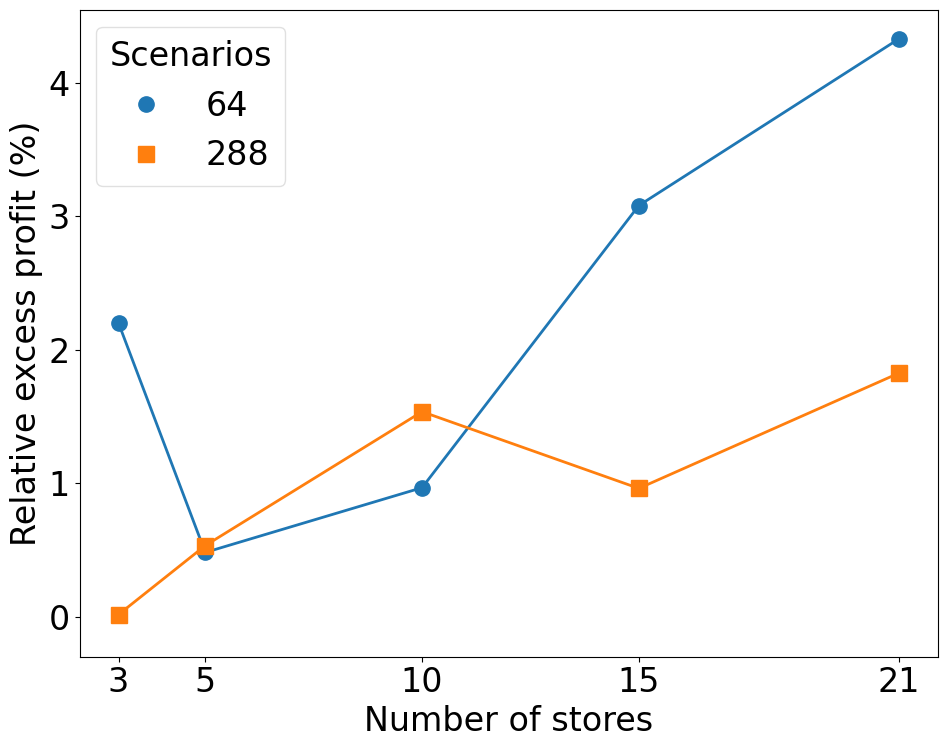

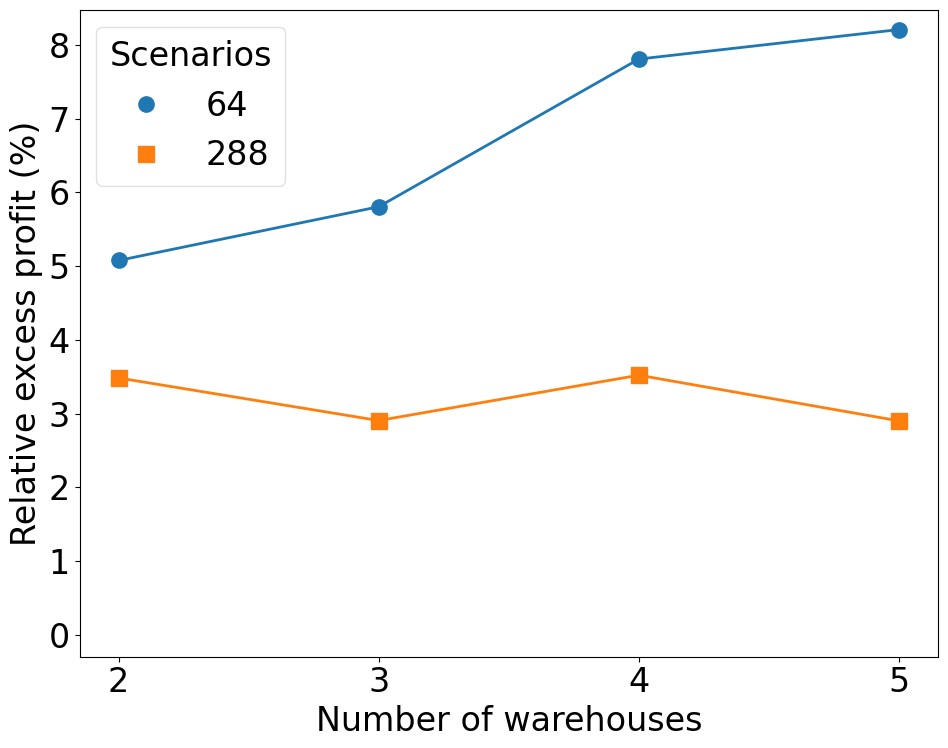

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

FONTSIZE = 24
MARKERSIZE = 11
LINEWIDTH = 2
FIGSIZE = (10, 8)
plt.rcParams.update({'font.size': FONTSIZE})

scenario_data = {
    "Real One Warehouse": real_one_warehouse_data,
    "Real Many Warehouses": real_many_warehouses_data,
}

problem_size_fields = {
    "Real One Warehouse": "n_stores",
    "Real Many Warehouses": "n_warehouses",
}
sample_size_fields = {
    "Real One Warehouse": "sample_size",
    "Real Many Warehouses": "sample_size",
}

sample_size_styles = {
    64:   {'marker': 'o',  'color': "#1f77b4", 'label': '64'},
    288:  {'marker': 's',  'color': "#ff7f0e", 'label': '288'},
}

scenario_ps_values = {}
scenario_ss_values = {}
for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = sorted(set(r[ps_field] for r in results))
    ss_list = sorted(set(r[ss_field] for r in results))
    scenario_ps_values[name] = ps_list
    scenario_ss_values[name] = ss_list

impr_vs_ps_by_ss = {}
for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = scenario_ps_values[name]
    ss_list = scenario_ss_values[name]
    impr_vs_ps_by_ss[name] = {}
    for ss in ss_list:
        ps_to_impr = {}
        for ps in ps_list:
            vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == ss]
            ps_to_impr[ps] = np.mean(vals) if vals else np.nan
        impr_vs_ps_by_ss[name][ss] = [ps_to_impr[ps] for ps in ps_list]

YLIM_BOTTOM = -0.3

# Plot for Real One Warehouse
name = "Real One Warehouse"
fig1, ax1 = plt.subplots(figsize=FIGSIZE)
ps_list = scenario_ps_values[name]
ss_list = scenario_ss_values[name]
plot_handles = []
plot_labels = []
legend_elements = []
for ss in ss_list:
    if ss not in sample_size_styles:
        continue
    y_vals = impr_vs_ps_by_ss[name][ss]
    style = sample_size_styles[ss]
    handle, = ax1.plot(
        ps_list, y_vals,
        marker=style['marker'],
        linestyle='-',
        color=style['color'],
        label=style['label'],
        markersize=MARKERSIZE,
        linewidth=LINEWIDTH
    )
    plot_handles.append(handle)
    plot_labels.append(style['label'])
    legend_elements.append(
        Line2D([0], [0], marker=style['marker'], color=style['color'], markerfacecolor=style['color'],
               markersize=MARKERSIZE, linestyle='None', label=style['label'])
    )

ax1.set_ylim(bottom=YLIM_BOTTOM)

ax1.set_xlabel("Number of stores", fontsize=FONTSIZE)
ax1.set_ylabel('Relative excess profit (%)', fontsize=FONTSIZE)
ax1.set_xticks(ps_list)
ax1.set_xticklabels([str(ps) for ps in ps_list], fontsize=FONTSIZE)
ax1.tick_params(labelsize=FONTSIZE)
ax1.legend(
    handles=legend_elements,
    fontsize=FONTSIZE,
    frameon=True,
    framealpha=0.6,
    title="Scenarios"
)
plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/sample_efficiency_OWMS_real_excess_profit.pdf', bbox_inches='tight')
plt.show()

# Plot for Real Many Warehouses
name = "Real Many Warehouses"
fig2, ax2 = plt.subplots(figsize=FIGSIZE)
ps_list = scenario_ps_values[name]
ss_list = scenario_ss_values[name]
plot_handles = []
plot_labels = []
legend_elements = []
for ss in ss_list:
    if ss not in sample_size_styles:
        continue
    y_vals = impr_vs_ps_by_ss[name][ss]
    style = sample_size_styles[ss]
    handle, = ax2.plot(
        ps_list, y_vals,
        marker=style['marker'],
        linestyle='-',
        color=style['color'],
        label=style['label'],
        markersize=MARKERSIZE,
        linewidth=LINEWIDTH
    )
    plot_handles.append(handle)
    plot_labels.append(style['label'])
    legend_elements.append(
        Line2D([0], [0], marker=style['marker'], color=style['color'], markerfacecolor=style['color'],
               markersize=MARKERSIZE, linestyle='None', label=style['label'])
    )

ax2.set_ylim(bottom=YLIM_BOTTOM)

ax2.set_xlabel("Number of warehouses", fontsize=FONTSIZE)
ax2.set_ylabel('Relative excess profit (%)', fontsize=FONTSIZE)
ax2.set_xticks(ps_list)
ax2.set_xticklabels([str(ps) for ps in ps_list], fontsize=FONTSIZE)
ax2.tick_params(labelsize=FONTSIZE)
ax2.legend(
    handles=legend_elements,
    fontsize=FONTSIZE,
    frameon=True,
    framealpha=0.6,
    title="Scenarios"
)
plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/sample_efficiency_MWMS_real_excess_profit.pdf', bbox_inches='tight')
plt.show()


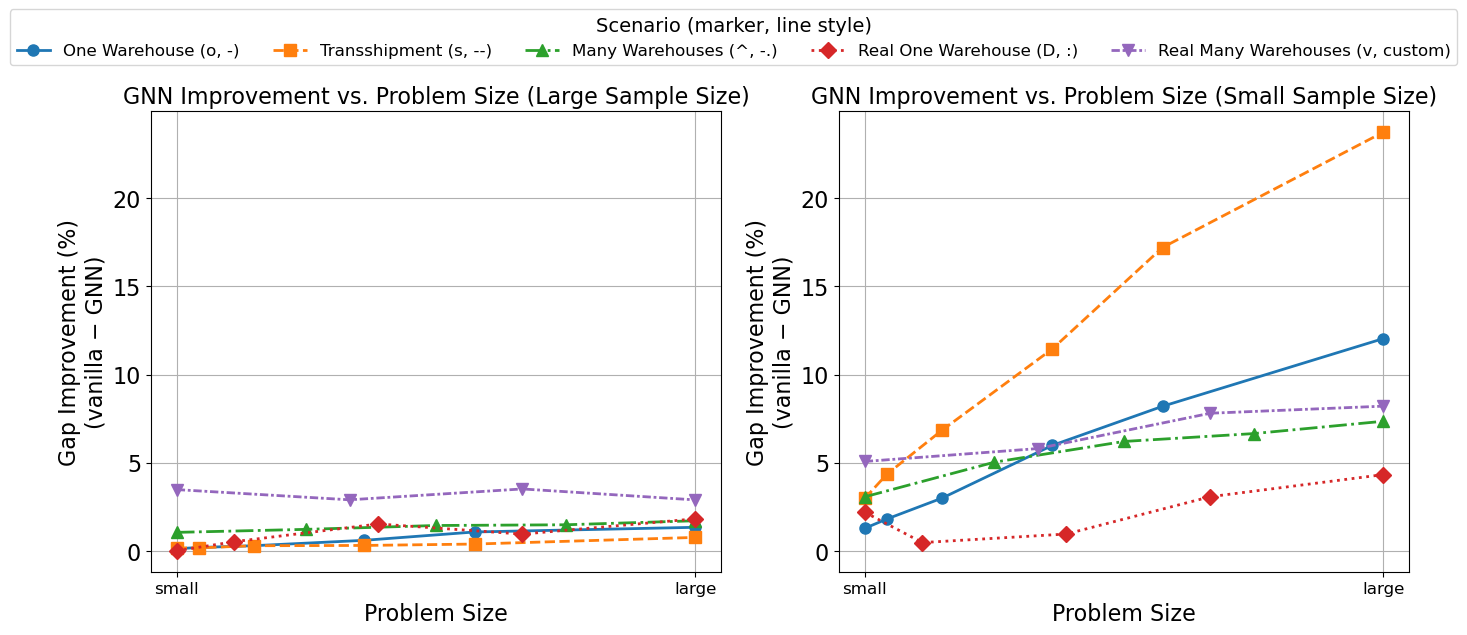

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

FONTSIZE = 16
plt.rcParams.update({'font.size': FONTSIZE})

scenario_data = {
    # "Serial System": serial_system_data,
    # "One Warehouse": one_warehouse_data,
    "Transshipment": transshipment_data,
    "Many Warehouses": many_warehouses_data,
    "Real One Warehouse": real_one_warehouse_data,
    "Real Many Warehouses": real_many_warehouses_data,
}

problem_size_fields = {
    # "Serial System": "system_length",
    # "One Warehouse": "n_stores",
    "Transshipment": "n_stores",
    "Many Warehouses": "n_stores",
    "Real One Warehouse": "n_stores",
    "Real Many Warehouses": "n_warehouses",
}
sample_size_fields = {
    "Serial System": "sample_size",
    # "One Warehouse": "sample_size",
    "Transshipment": "sample_size",
    "Many Warehouses": "sample_size",
    "Real One Warehouse": "sample_size",
    "Real Many Warehouses": "sample_size",
}

# Assign unique marker, line style, and color for each scenario
bw_markers = ['o', 's', '^', 'D', 'v', 'P', 'X']
bw_linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1))]
bw_colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
]
scenario_styles = {}
for i, name in enumerate(scenario_data.keys()):
    marker = bw_markers[i % len(bw_markers)]
    linestyle = bw_linestyles[i % len(bw_linestyles)]
    color = bw_colors[i % len(bw_colors)]
    scenario_styles[name] = {'marker': marker, 'linestyle': linestyle, 'color': color}

scenario_ps_values = {}
scenario_ss_values = {}
for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = sorted(set(r[ps_field] for r in results))
    ss_list = sorted(set(r[ss_field] for r in results))
    scenario_ps_values[name] = ps_list
    scenario_ss_values[name] = ss_list

impr_vs_ps_large = {}
impr_vs_ps_small = {}
norm_ps_ticks = {}
ps_tick_labels = {}

for name, data in scenario_data.items():
    if data is None:
        continue
    results = data["results"]
    ps_field = problem_size_fields[name]
    ss_field = sample_size_fields[name]
    ps_list = scenario_ps_values[name]
    ss_list = scenario_ss_values[name]
    if len(ps_list) > 1:
        min_ps = min(ps_list)
        max_ps = max(ps_list)
        ps_range = max_ps - min_ps
        if ps_range == 0:
            x_ps = np.array([0.5 for _ in ps_list])
        else:
            x_ps = np.array([(ps - min_ps) / ps_range for ps in ps_list])
    else:
        x_ps = np.array([0.5])
    norm_ps_ticks[name] = x_ps
    ps_tick_labels[name] = [str(ps) for ps in ps_list]
    if not ss_list:
        continue
    large_sample_size = max(ss_list)
    small_sample_size = min(ss_list)
    ps_to_impr_large = {}
    for ps in ps_list:
        vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == large_sample_size]
        ps_to_impr_large[ps] = np.mean(vals) if vals else np.nan
    impr_vs_ps_large[name] = [ps_to_impr_large[ps] for ps in ps_list]
    ps_to_impr_small = {}
    for ps in ps_list:
        vals = [r['improvement_percentage'] for r in results if r[ps_field] == ps and r[ss_field] == small_sample_size]
        ps_to_impr_small[ps] = np.mean(vals) if vals else np.nan
    impr_vs_ps_small[name] = [ps_to_impr_small[ps] for ps in ps_list]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.4)

plot_handles = []
plot_labels = []
for name in scenario_data:
    if name not in impr_vs_ps_large or name not in impr_vs_ps_small:
        continue
    x_ps = norm_ps_ticks[name]
    y_ps_large = impr_vs_ps_large[name]
    y_ps_small = impr_vs_ps_small[name]
    style = scenario_styles[name]
    handle1, = ax1.plot(
        x_ps, y_ps_large,
        marker=style['marker'],
        linestyle=style['linestyle'],
        color=style['color'],
        label=name,
        markersize=8,
        linewidth=2
    )
    ax2.plot(
        x_ps, y_ps_small,
        marker=style['marker'],
        linestyle=style['linestyle'],
        color=style['color'],
        label=name,
        markersize=8,
        linewidth=2
    )
    plot_handles.append(handle1)
    plot_labels.append(
        f"{name} ({style['marker']}, {style['linestyle'] if isinstance(style['linestyle'], str) else 'custom'})"
    )

all_y_values = []
for y_list in impr_vs_ps_large.values():
    all_y_values.extend([y for y in y_list if not np.isnan(y)])
for y_list in impr_vs_ps_small.values():
    all_y_values.extend([y for y in y_list if not np.isnan(y)])
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    y_margin = 0.05 * (y_max - y_min) if y_max > y_min else 1
    y_lower = y_min - y_margin
    y_upper = y_max + y_margin
    ax1.set_ylim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)

for ax, title, sample_size_label in zip(
    [ax1, ax2],
    ['GNN Improvement vs. Problem Size (Large Sample Size)', 'GNN Improvement vs. Problem Size (Small Sample Size)'],
    ['large', 'small']
):
    ax.set_xlabel('Problem Size', fontsize=FONTSIZE)
    ax.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
    ax.set_title(title, fontsize=FONTSIZE)
    ax.grid(True)
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['small', 'large'], fontsize=FONTSIZE-4)

fig.legend(
    handles=plot_handles,
    labels=plot_labels,
    title='Scenario (marker, line style)',
    fontsize=FONTSIZE-4,
    title_fontsize=FONTSIZE-2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=len(plot_labels),
    frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


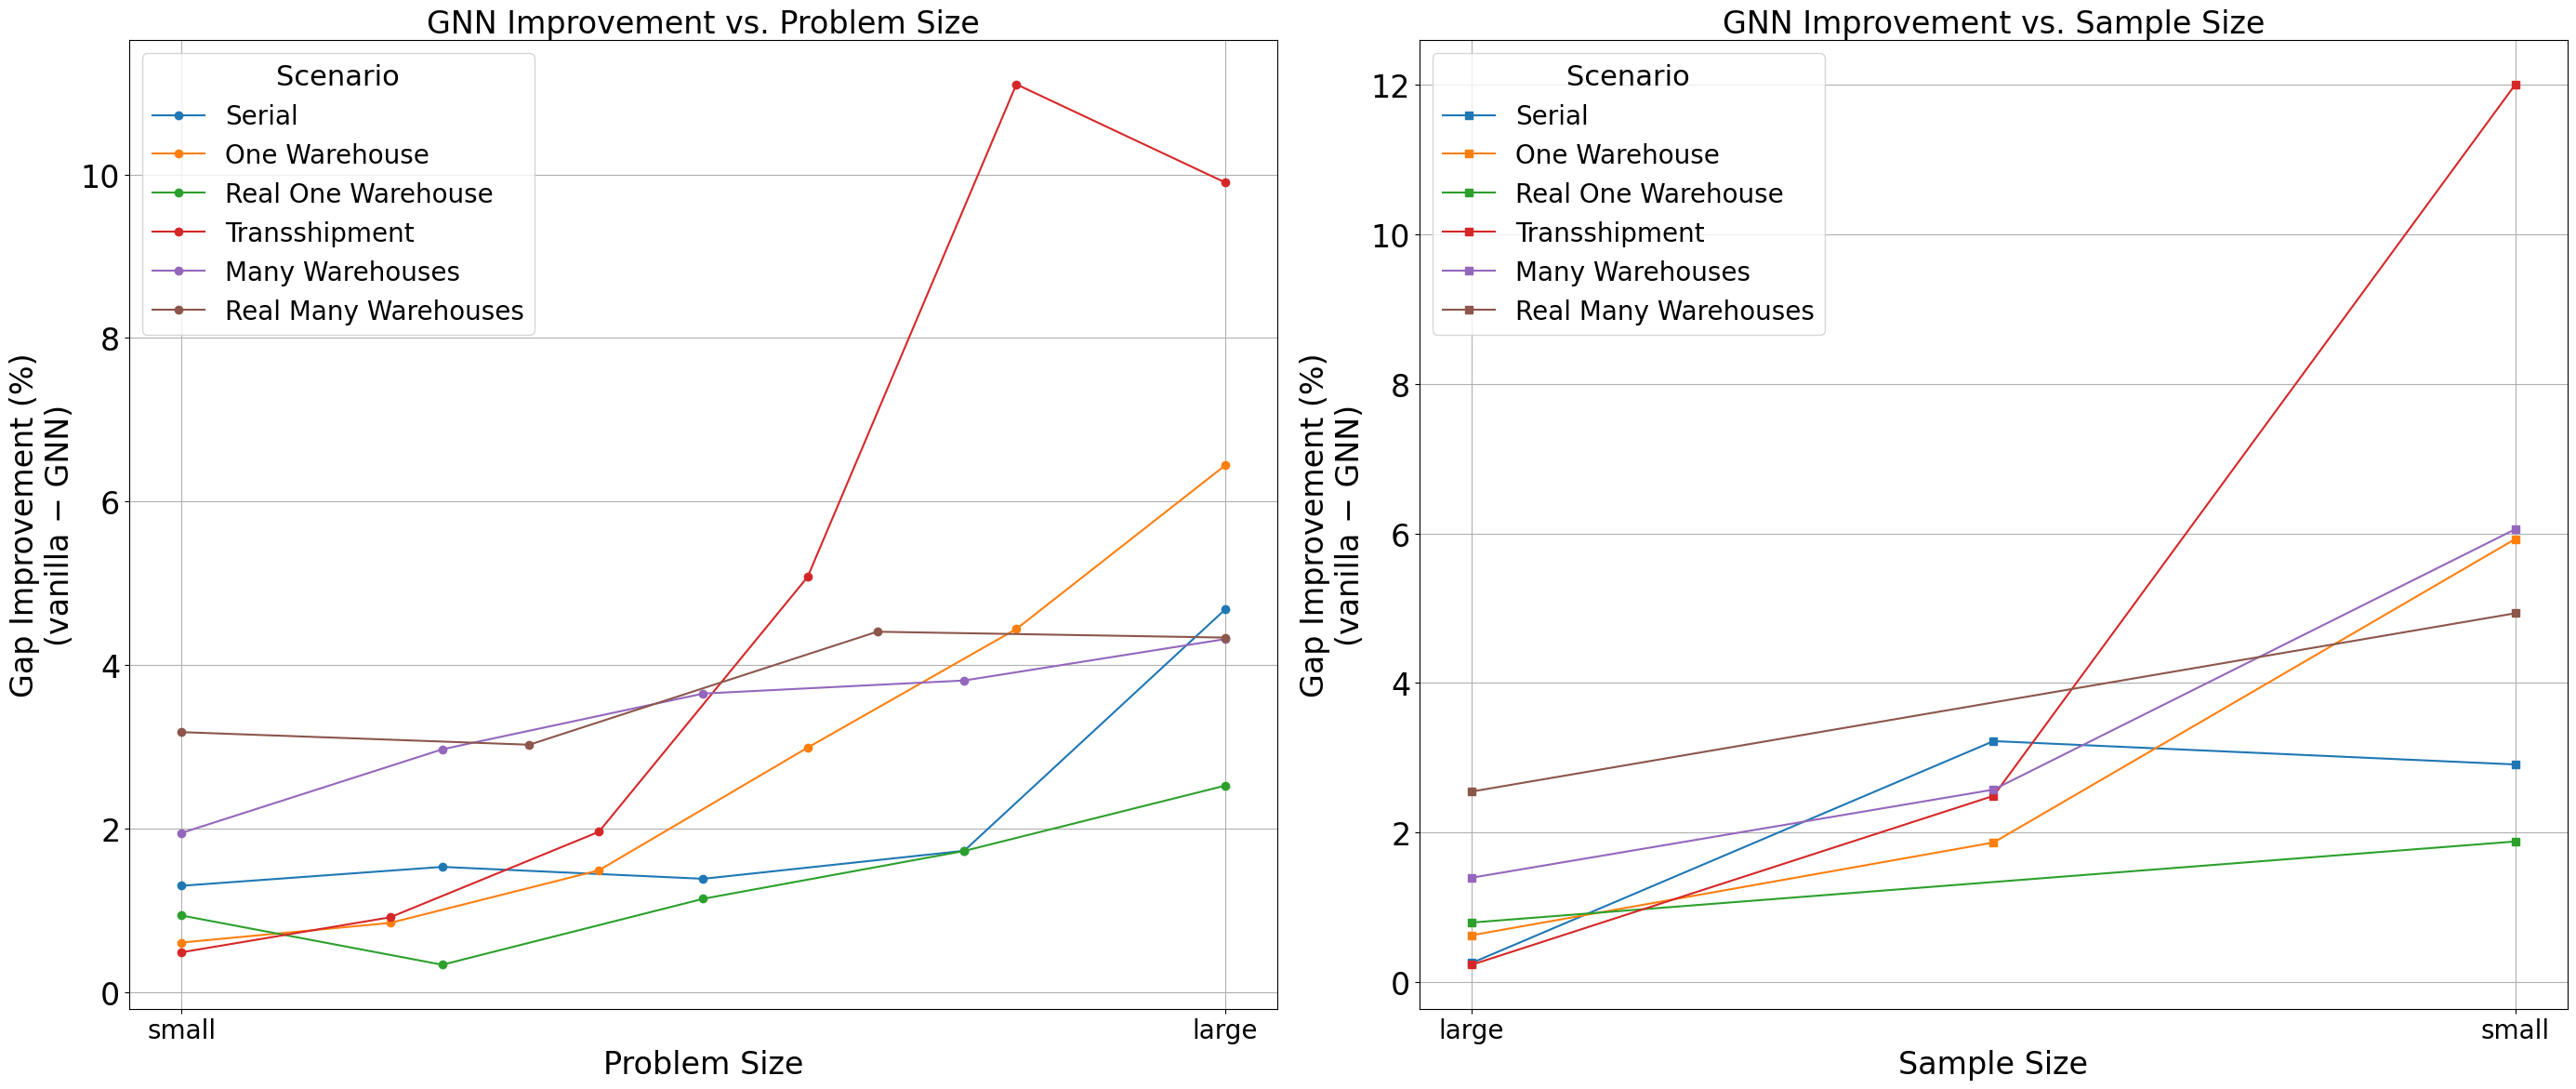

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# … (your data + computations for impr_vs_ps & impr_vs_ss) …

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))
plt.subplots_adjust(wspace=0.4)

for name, (data, field) in scenarios.items():
    # 1) per‐scenario problem sizes
    ps_list = sorted({
        entry[field]
        for lst in data["stats"].values()
        for entry in lst
    })
    # 2) per‐scenario sample sizes
    ss_list = sorted({
        s
        for (model, s), lst in data["stats"].items()
        if lst  # only keep s if there's at least one entry
    })

    # 3) build normalized x’s
    x_ps = np.linspace(0, 1, len(ps_list))
    x_ss = np.linspace(1, 0, len(ss_list))  # reversed

    # 4) extract the y’s in that order
    y_ps = [impr_vs_ps[name][all_problem_sizes.index(ps)] for ps in ps_list]
    y_ss = [impr_vs_ss[name][all_sample_sizes.index(s)]    for s  in ss_list]

    ax1.plot(x_ps, y_ps, marker='o', label=name)
    ax2.plot(x_ss, y_ss, marker='s', label=name)

# Problem‐size: small→large
ax1.set_xlabel('Problem Size', fontsize=FONTSIZE)
ax1.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax1.set_title('GNN Improvement vs. Problem Size', fontsize=FONTSIZE)
ax1.grid(True)
ax1.tick_params(labelsize=FONTSIZE)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['small', 'large'], fontsize=FONTSIZE-4)
ax1.legend(title='Scenario', fontsize=FONTSIZE-4, title_fontsize=FONTSIZE-2)

# Sample‐size: large→small
ax2.set_xlabel('Sample Size', fontsize=FONTSIZE)
ax2.set_ylabel('Gap Improvement (%)\n(vanilla − GNN)', fontsize=FONTSIZE)
ax2.set_title('GNN Improvement vs. Sample Size', fontsize=FONTSIZE)
ax2.grid(True)
ax2.tick_params(labelsize=FONTSIZE)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['large', 'small'], fontsize=FONTSIZE-4)
ax2.legend(title='Scenario', fontsize=FONTSIZE-4, title_fontsize=FONTSIZE-2)

plt.tight_layout()
plt.show()
